In [13]:
import torch 
import os 
import random 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from tqdm import tqdm

from utils import sent_to_tensor, read_txt_file,get_vocab_tag
from dataset import Data_class
from model import NER_model
from predict import predict
from trainer_evaluater import Trainer_Evaluater

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

%load_ext autoreload
%autoreload 2

CUDA_LAUNCH_BLOCKING=1

random.seed(32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Set device to CUDA if available. Otherwise, device = CPU 
device = 'cuda'if torch.cuda.is_available() else 'cpu'

# Data directory  
#======== Change this dir if you downloaded the data in another folder ==========
data_dir = './data' 

#Set the max_length (length of sequence) and batch_size 
max_length = 50
batch_size = 64 

#Params for the NER model
num_lstm_layers = 3 
hidden_dim = 256

#Learning rate and number of epochs
lr = 0.001
num_epochs = 20

#print loss and acc every number of epochs 
print_every = 10

In [3]:
#Get vocabulary as list of words and tags as list of tags
vocab_sent = read_txt_file(os.path.join(data_dir,'words.txt'))
vocab_tags = read_txt_file(os.path.join(data_dir,'tags.txt'))

#Get train/val/test sentences as list
train_sent = read_txt_file(os.path.join(data_dir,'train/sentences.txt'))
train_labels = read_txt_file(os.path.join(data_dir,'train/labels.txt'))

val_sent = read_txt_file(os.path.join(data_dir,'val/sentences.txt'))
val_labels = read_txt_file(os.path.join(data_dir,'val/labels.txt'))

test_sent = read_txt_file(os.path.join(data_dir,'test/sentences.txt'))
test_labels = read_txt_file(os.path.join(data_dir,'test/labels.txt'))

#Check the number of sentences and labels in each subset
print('Check the length of sentences/labels')
print(f'Length of training sample: {len(train_sent)} \t Length of training labels: {len(train_labels)}')
print(f'Length of val sample: {len(val_sent)} \t Length of val labels: {len(val_labels)}')
print(f'Length of test sample: {len(test_sent)} \t Length of test labels: {len(test_labels)}')

Check the length of sentences/labels
Length of training sample: 33570 	 Length of training labels: 33570
Length of val sample: 7194 	 Length of val labels: 7194
Length of test sample: 7194 	 Length of test labels: 7194


In [4]:
#Get voabculary and tags dict, maps each tag and word to int. 
vocab, tag_map = get_vocab_tag(vocab_sent = vocab_sent, vocab_tags = vocab_tags , padding = '<PAD>')

#Check the vocab and tag_map
print(f'vocab["the"] = {vocab["the"]} \t vocab["The"] = {vocab["The"]} \t padded_token = {vocab["<PAD>"]}')
print(f'Length of words vocabulary = {len(vocab)}')
print(f'Length of tag vocabulary = {len(tag_map)}')


vocab["the"] = 9 	 vocab["The"] = 61 	 padded_token = 35180
Length of words vocabulary = 35181
Length of tag vocabulary = 18


In [5]:
#Get the sentences and labels as tensor of int 
#Map each word to int (from vocab) and each tag to int (from tag_map)

train_tensors, train_labels_tensor = sent_to_tensor(vocab, tag_map, sentences = train_sent, labels = train_labels)
val_tensors, val_labels_tensor = sent_to_tensor(vocab, tag_map, sentences = val_sent, labels = train_labels)
test_tensors, test_labels_tensor = sent_to_tensor(vocab, tag_map, sentences = test_sent, labels = train_labels)

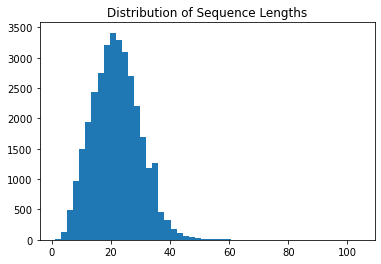

In [6]:
#Distribution of the sequence length

length = [len(s.split(' ')) for s in train_sent]
plt.hist(length, bins = 50)
plt.title('Distribution of Sequence Lengths')
plt.show()

In [7]:
#Create Dataset for train/test
train_dataset = Data_class(vocab, tag_map, train_sent, train_labels, max_length=max_length)
test_dataset = Data_class(vocab, tag_map, test_sent, test_labels, max_length=max_length)

#Create DataLoader for train/test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
#Instantiate model object
model = NER_model( vocab = vocab, tag_map= tag_map, num_layers= num_lstm_layers, d_model = hidden_dim).to(device)

#Define optimizer and criterion 
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
#Instantiate an object to train and evaluate the NER model. 
trainer = Trainer_Evaluater(
    model = model, num_epochs = num_epochs,
    optimizer = optimizer,tag_map = tag_map, vocab = vocab,
    device = device, criterion = criterion, print_every = print_every
    )

In [10]:
#Train the model
print('============= Training ===================')
train_acc_list , train_loss_list = trainer.fit(train_loader = train_loader)

print('============= Evaluation =================')
#Evaluate on the Test set
test_acc = trainer.evaluate(test_loader = test_loader)


============= Training ===================
Epoch 1 / 20


100%|██████████| 525/525 [00:09<00:00, 53.23it/s]


Epoch 2 / 20


100%|██████████| 525/525 [00:09<00:00, 58.07it/s]


Epoch 3 / 20


100%|██████████| 525/525 [00:09<00:00, 56.75it/s]


Epoch 4 / 20


100%|██████████| 525/525 [00:09<00:00, 56.46it/s]


Epoch 5 / 20


100%|██████████| 525/525 [00:09<00:00, 56.20it/s]


Epoch 6 / 20


100%|██████████| 525/525 [00:09<00:00, 56.42it/s]


Epoch 7 / 20


100%|██████████| 525/525 [00:09<00:00, 53.95it/s]


Epoch 8 / 20


100%|██████████| 525/525 [00:09<00:00, 58.18it/s]


Epoch 9 / 20


100%|██████████| 525/525 [00:09<00:00, 55.46it/s]


Epoch 10 / 20


100%|██████████| 525/525 [00:09<00:00, 55.29it/s]


Loss = 0.011
Acc = 99.177%
Epoch 11 / 20


100%|██████████| 525/525 [00:09<00:00, 56.78it/s]


Epoch 12 / 20


100%|██████████| 525/525 [00:09<00:00, 55.54it/s]


Epoch 13 / 20


100%|██████████| 525/525 [00:08<00:00, 58.75it/s]


Epoch 14 / 20


100%|██████████| 525/525 [00:08<00:00, 58.92it/s]


Epoch 15 / 20


100%|██████████| 525/525 [00:08<00:00, 60.14it/s]


Epoch 16 / 20


100%|██████████| 525/525 [00:08<00:00, 59.13it/s]


Epoch 17 / 20


100%|██████████| 525/525 [00:08<00:00, 61.41it/s]


Epoch 18 / 20


100%|██████████| 525/525 [00:09<00:00, 57.76it/s]


Epoch 19 / 20


100%|██████████| 525/525 [00:08<00:00, 62.03it/s]


Epoch 20 / 20


100%|██████████| 525/525 [00:08<00:00, 59.24it/s]


Loss = 0.006
Acc = 99.466%
============= Evaluation =================


100%|██████████| 113/113 [00:01<00:00, 109.44it/s]


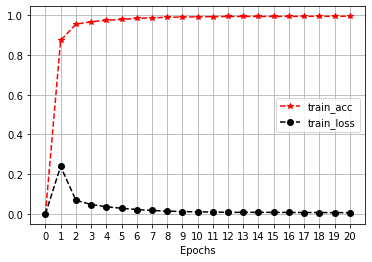

In [30]:
#plot loss and acc plots 
plt.plot([0] + train_acc_list,'--*',label='train_acc', color = 'red')
plt.plot([0] + train_loss_list,'--o' ,label= 'train_loss', color = 'black')
plt.xticks([i for i in range(num_epochs+1)])
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show()

In [19]:
sentence = input('Enter your sentence to get the result from NER model')
print(f'The input sentence')
print(sentence)
print('================================ ')
print('The word tags are:')
predictions = trainer.predict(sentence)

The input sentence
George Alexander will come from France to Dubai, he will stay for three weeks.
The word tags are:
George 	 B-per
Alexander 	 I-per
France 	 B-geo
Dubai, 	 B-geo
three 	 B-tim
weeks. 	 I-tim


In [18]:
# Inference: Run this cell, input your sentence to get the Result.
sentence = input('Enter your sentence to get the result from NER model')
print(sentence, '\n')
model.eval()
predictions = predict(sentence, model, vocab, tag_map)

George Alexander will come from France to Dubai, he will stay for three weeks. 

George B-per
Alexander I-per
France B-geo
Dubai, B-geo
three B-tim
weeks. I-tim
